In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-market-costs/test_data_cleaned.csv
/kaggle/input/predicting-market-costs/Train_Batch_2.csv
/kaggle/input/predicting-market-costs/Train_Batch_1.csv
/kaggle/input/predicting-market-costs/Train_Batch_3.csv
/kaggle/input/predicting-market-costs/test.csv
/kaggle/input/predicting-market-costs/train_data_cleaned.csv


In [2]:
!pip install lazypredict

In [3]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor, VotingRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [4]:
df = pd.read_csv("../input/predicting-market-costs/train_data_cleaned.csv")
print(df.shape)
df.head()

(28218, 26)


,Promotion Name,Store Kind,Store Sales,Store Cost,Is Recyclable?,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,...,Store Code,Country ISO2,Order Brand,Order,Department,Amenities Score,Gross Weight,Net Weight,Package Weight,Min. Person Yearly Income
0,Dimes Off,Deluxe,8760000.00,4292400.00,yes,2842.23,2037.64,481.98,323.00,602.76,...,H11go,ZA,Red Wing,Cleaning Supplies,Household,5,28.20,26.60,1.60,10000.00
1,Budget Bargains,Supermarket,6360000.00,1971600.00,no,2814.95,2049.72,457.36,304.98,708.66,...,S04ne,WA,Nationeel,Snack Foods,Snack Foods,0,16.57,14.97,1.60,50000.00
2,Shelf Emptiers,Supermarket,10860000.00,4452600.00,yes,2192.32,1322.21,523.32,348.85,564.26,...,L05es,CA,Excel,Magazines,Periodicals,1,28.64,27.18,1.45,30000.00
3,Sale Winners,Deluxe,11560000.00,4970800.00,no,2862.30,1872.19,593.93,395.95,519.76,...,M10da,YU,Hermanos,Vegetables,Produce,5,12.62,9.71,2.91,50000.00
4,Weekend Discount,Supermarket,5220000.00,1618200.00,yes,1970.17,1236.07,440.92,293.95,364.16,...,S03le,WA,Red Wing,Candles,Household,1,15.41,13.95,1.45,30000.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28218 entries, 0 to 28217
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28218 non-null  object 
 1   Store Kind                 28218 non-null  object 
 2   Store Sales                28218 non-null  float64
 3   Store Cost                 28218 non-null  float64
 4   Is Recyclable?             28218 non-null  object 
 5   Store Area                 28218 non-null  float64
 6   Grocery Area               28218 non-null  float64
 7   Frozen Area                28218 non-null  float64
 8   Meat Area                  28218 non-null  float64
 9   Cost                       28218 non-null  float64
 10  Degree Work                28218 non-null  object 
 11  Marriage                   28218 non-null  object 
 12  Gender                     28218 non-null  object 
 13  Children                   28218 non-null  obj

In [6]:
df.isna().sum()

Promotion Name               0
Store Kind                   0
Store Sales                  0
Store Cost                   0
Is Recyclable?               0
Store Area                   0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Cost                         0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Net Weight                   0
Package Weight               0
Min. Person Yearly Income    0
dtype: int64

our data looks clean to model building!!

if you want to take a look on this data pre-processing you will find it by clicking on this [link](https://www.kaggle.com/code/kershrita/market-costs-data-preprocessing-guide)

# Feature Engineering

we dropped a column in pre-processing notebook called `Place Code` after splitting it so we will get it back because it add performance to the model

In [7]:
# Step 1
df["Store CountryISO2"] = df["Store Code"] + '_' + df["Country ISO2"]

we will create new column called `Income Level` that represents the classes of this persons based on there income:

- [0 -> 25,000] USD represents `Low` class
- [25,000 -> 50,000] USD represents `Middle` class
- [50,000 -> +inf] USD represents `High` class

In [8]:
# Step 2
df['Income Level'] = (
    pd.cut(
        df['Min. Person Yearly Income'],
        bins=[0, 25000, 50000, float('inf')],
        labels=['Low', 'Middle', 'High']
    )
    .astype("object")
)

like we did above with `Min. Person Yearly Income` column we will do to `Gross Weight`, we will calculate column called `Price Tier` that represents the classes of orders prices:

- [0 -> 5] Kg represents `Low Price` class
- [5 -> 10] Kg represents `Middle Price` class
- [10 -> +inf] Kg represents `High Price` class

In [9]:
# Step 3
df['Price Tier'] = (
    pd.cut(
        df['Gross Weight'],
        bins=[0, 5, 10, float('inf')],
        labels=['Low Price', 'Medium Price', 'High Price']
    )
    .astype("object")
)

we can calculate from `Order` column the popularity of each product in the whole dataset 

In [10]:
# Step 4
order_popularity = df['Order'].value_counts().reset_index()
order_popularity.columns = ['Order', 'Order Popularity']
df = df.merge(order_popularity, on='Order', how='left')

from `Min. Person Yearly Income` column & `Children` we can extract something it maybe important for our model, a column we will name `Family Expenses` that represents the expenses of each person in the family based on `Min. Person Yearly Income` column

In [11]:
# Step 5
def calculate_family_expenses(row):
    if row["Marriage"] == "Married":
        return row["Min. Person Yearly Income"] / (row["Children"] + 2)
    else:
        return row["Min. Person Yearly Income"] / (row["Children"] + 1)

children_mapping = {
    'No': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5
}

temp_df = df.copy()
temp_df['Children'] = temp_df['Children'].map(children_mapping)
temp_df["Family Expenses"] = temp_df.apply(lambda row: calculate_family_expenses(row), axis=1)

df["Family Expenses"] = temp_df["Family Expenses"]

now let's gooooo with our king column, we will concat it with every info about the person like `Gender`, `Marriage`, `Children`, etc.. then calculate `Promotion Name Length` column

In [12]:
# Step 6
person_description = ["Gender", "Marriage", "Children", "Degree", "Work"]
for col in person_description:
    df['Promotion '+ col] = df['Promotion Name'] + ' ' + df[col]
    
df['Promotion Name Length'] = (df['Promotion Name'].apply(lambda x: len(x))).astype(int)

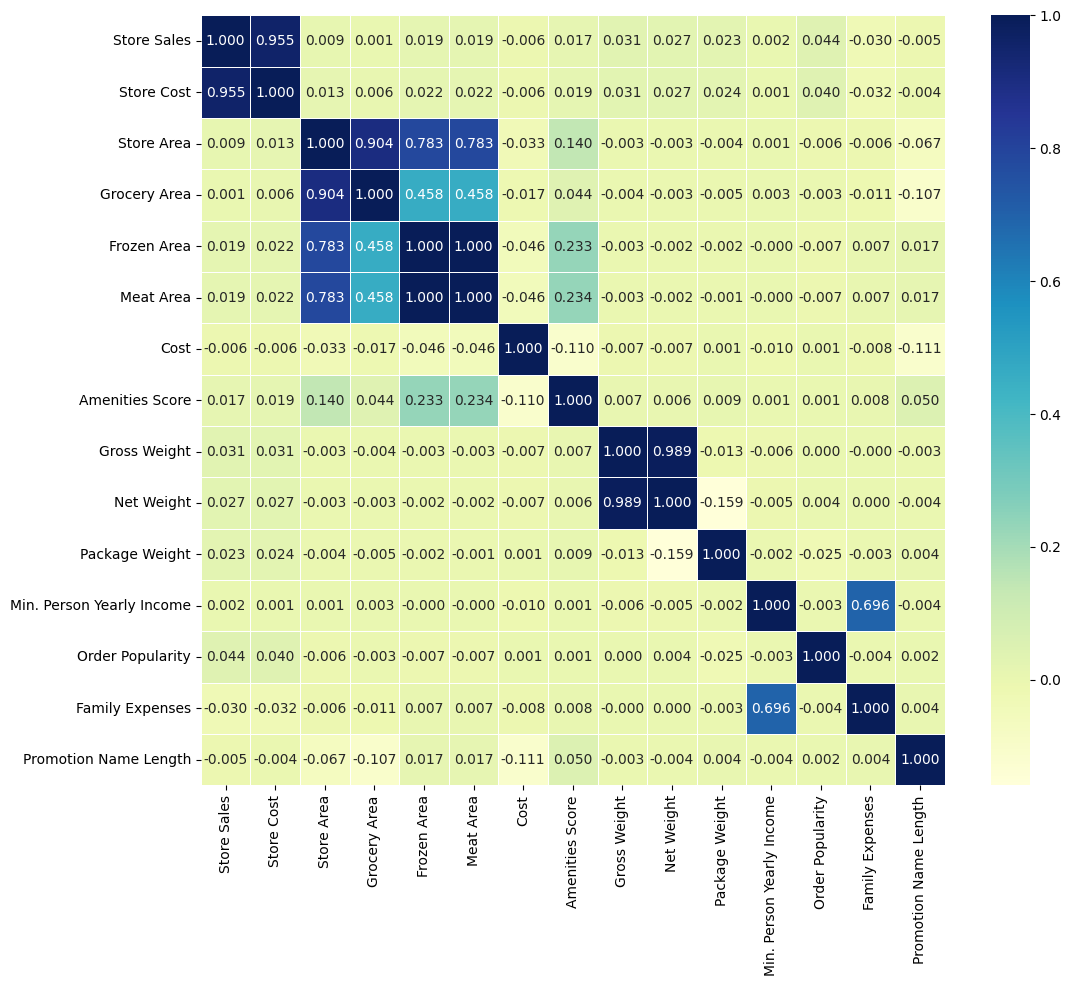

In [13]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(df.select_dtypes("number").corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

Hmmmmmm?

there is a lot of **multilinearity** columns above we need to drop some of them to improve our model performance

In [14]:
# Step 7
df.drop(columns=["Store Sales", "Frozen Area", "Net Weight", "Store Area", 'Is Recyclable?'], inplace = True)

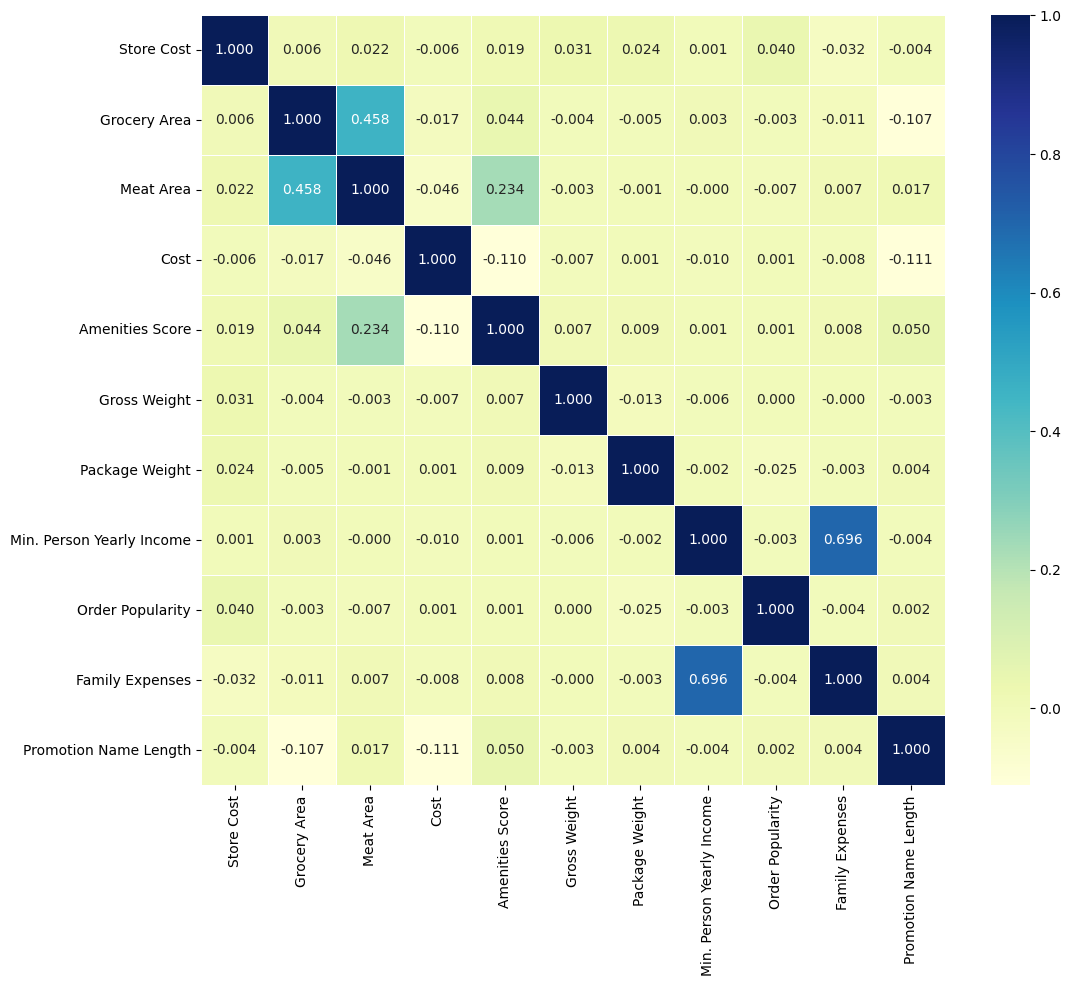

In [15]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(df.select_dtypes("number").corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28218 entries, 0 to 28217
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28218 non-null  object 
 1   Store Kind                 28218 non-null  object 
 2   Store Cost                 28218 non-null  float64
 3   Grocery Area               28218 non-null  float64
 4   Meat Area                  28218 non-null  float64
 5   Cost                       28218 non-null  float64
 6   Degree Work                28218 non-null  object 
 7   Marriage                   28218 non-null  object 
 8   Gender                     28218 non-null  object 
 9   Children                   28218 non-null  object 
 10  Degree                     28218 non-null  object 
 11  Work                       28218 non-null  object 
 12  Store Code                 28218 non-null  object 
 13  Country ISO2               28218 non-null  obj

now everything is clear, we need to create a function that includes all this features engineering to handle test data after model building

In [17]:
def apply_feature_engineering(df):
    # Step 1
    df["Store CountryISO2"] = df["Store Code"] + '_' + df["Country ISO2"]
    
    # Step 2
    df['Income Level'] = (
        pd.cut(
            df['Min. Person Yearly Income'],
            bins=[0, 25000, 50000, float('inf')],
            labels=['Low', 'Middle', 'High']
        )
        .astype("object")
    )
    
    # Step 3
    df['Price Tier'] = (
        pd.cut(
            df['Gross Weight'],
            bins=[0, 5, 10, float('inf')],
            labels=['Low Price', 'Medium Price', 'High Price']
        )
        .astype("object")
    )
    
    # Step 4
    order_popularity = df['Order'].value_counts().reset_index()
    order_popularity.columns = ['Order', 'Order Popularity']
    df = df.merge(order_popularity, on='Order', how='left')
    
    # Step 5
    def calculate_family_expenses(row):
        if row["Marriage"] == "Married":
            return row["Min. Person Yearly Income"] / (row["Children"] + 2)
        else:
            return row["Min. Person Yearly Income"] / (row["Children"] + 1)

    children_mapping = {
        'No': 0,
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5
    }

    temp_df = df.copy()
    temp_df['Children'] = temp_df['Children'].map(children_mapping)
    temp_df["Family Expenses"] = temp_df.apply(lambda row: calculate_family_expenses(row), axis=1)
    df["Family Expenses"] = temp_df["Family Expenses"]
    
    # Step 6
    person_description = ["Gender", "Marriage", "Children", "Degree", "Work"]
    for col in person_description:
        df['Promotion '+ col] = df['Promotion Name'] + ' ' + df[col]

    df['Promotion Name Length'] = (df['Promotion Name'].apply(lambda x: len(x))).astype(int)
    
    # Step 7
    df.drop(columns=["Store Sales", "Frozen Area", "Net Weight", "Store Area", 'Is Recyclable?'], inplace = True)

# Model Building

## Data Splitting

In [18]:
target = "Cost"
X = df.drop(columns=target)
y = df[target]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Transformation

In [20]:
categorical_columns = df.select_dtypes("object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
    ]
)

In [21]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Try Lazypredict

In [22]:
reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  2%|▏         | 1/42 [00:00<00:26,  1.57it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.14926661792903395, 'Adjusted R-Squared': 0.14608885182738152, 'RMSE': 144.98876604325787, 'Time taken': 0.6352713108062744}


  5%|▍         | 2/42 [00:01<00:36,  1.10it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.894793221432387, 'Adjusted R-Squared': 0.8944002398689008, 'RMSE': 50.98700215497209, 'Time taken': 1.0934181213378906}


  7%|▋         | 3/42 [00:01<00:22,  1.70it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.016937146299012773, 'Adjusted R-Squared': 0.013265086546661142, 'RMSE': 155.8576987250082, 'Time taken': 0.20406007766723633}


 14%|█▍        | 6/42 [00:02<00:08,  4.01it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8386175329664859, 'Adjusted R-Squared': 0.8380147169210032, 'RMSE': 63.14890023997532, 'Time taken': 0.27500367164611816}
{'Model': 'DummyRegressor', 'R-Squared': -0.00022511450858475612, 'Adjusted R-Squared': -0.0039612808914877284, 'RMSE': 157.2122900585577, 'Time taken': 0.02983546257019043}
{'Model': 'ElasticNet', 'R-Squared': 0.014738115822016118, 'Adjusted R-Squared': 0.011057841975033234, 'RMSE': 156.03192175378658, 'Time taken': 0.08101940155029297}


 19%|█▉        | 8/42 [00:03<00:15,  2.26it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.017325335577310974, 'Adjusted R-Squared': 0.013654725838272097, 'RMSE': 155.82692334717598, 'Time taken': 1.3106236457824707}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.87723074146347, 'Adjusted R-Squared': 0.8767721583205907, 'RMSE': 55.078541687962705, 'Time taken': 0.1738901138305664}


 24%|██▍       | 10/42 [00:10<00:49,  1.55s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9214100279719897, 'Adjusted R-Squared': 0.921116468844884, 'RMSE': 44.067781110150285, 'Time taken': 6.3466269969940186}
{'Model': 'GammaRegressor', 'R-Squared': 0.01345359547884295, 'Adjusted R-Squared': 0.009768523530258033, 'RMSE': 156.1336007580143, 'Time taken': 0.12180972099304199}


 26%|██▌       | 11/42 [03:50<33:57, 65.74s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.9677609506564995, 'Adjusted R-Squared': -0.9751111783270412, 'RMSE': 220.50771323464585, 'Time taken': 220.23626732826233}


 29%|██▊       | 12/42 [03:55<23:50, 47.69s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.46483339821221925, 'Adjusted R-Squared': 0.46283437675410055, 'RMSE': 114.99583677026202, 'Time taken': 4.639155387878418}


 31%|███       | 13/42 [03:56<16:21, 33.84s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8426342548565232, 'Adjusted R-Squared': 0.8420464425747707, 'RMSE': 62.358077545033936, 'Time taken': 1.0271670818328857}


 33%|███▎      | 14/42 [03:57<11:13, 24.05s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.017152221937549283, 'Adjusted R-Squared': 0.013480965562716274, 'RMSE': 155.84064842776627, 'Time taken': 0.9414405822753906}


 36%|███▌      | 15/42 [03:58<07:42, 17.12s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.15477373367891845, 'Adjusted R-Squared': 0.15161653844719614, 'RMSE': 144.51872082578893, 'Time taken': 0.8324418067932129}


 40%|████      | 17/42 [05:17<10:24, 24.98s/it]

{'Model': 'KernelRidge', 'R-Squared': -10.99060586479074, 'Adjusted R-Squared': -11.035394680721122, 'RMSE': 544.3248735805114, 'Time taken': 78.8496904373169}
{'Model': 'Lars', 'R-Squared': -421957.37617675355, 'Adjusted R-Squared': -423533.52806215227, 'RMSE': 102110.97490877924, 'Time taken': 0.17473673820495605}


 43%|████▎     | 18/42 [05:17<07:03, 17.66s/it]

{'Model': 'LarsCV', 'R-Squared': 0.015721189216443165, 'Adjusted R-Squared': 0.012044587468585721, 'RMSE': 155.9540596568909, 'Time taken': 0.5215468406677246}


 45%|████▌     | 19/42 [05:17<04:46, 12.47s/it]

{'Model': 'Lasso', 'R-Squared': 0.016338659601611516, 'Adjusted R-Squared': 0.012664364306633535, 'RMSE': 155.90513443390654, 'Time taken': 0.334881067276001}


 50%|█████     | 21/42 [05:19<02:17,  6.55s/it]

{'Model': 'LassoCV', 'R-Squared': 0.017864792477625846, 'Adjusted R-Squared': 0.014196197785706688, 'RMSE': 155.7841454817798, 'Time taken': 1.8198192119598389}
{'Model': 'LassoLars', 'R-Squared': 0.01634244540836871, 'Adjusted R-Squared': 0.012668164254611258, 'RMSE': 155.9048344184159, 'Time taken': 0.16666388511657715}


 52%|█████▏    | 22/42 [05:20<01:34,  4.74s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.018679808419840405, 'Adjusted R-Squared': 0.015014258077758691, 'RMSE': 155.71949404041766, 'Time taken': 0.5076470375061035}


 57%|█████▋    | 24/42 [05:20<00:43,  2.44s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.0199630142822933, 'Adjusted R-Squared': 0.016302257131800335, 'RMSE': 155.61764882469177, 'Time taken': 0.3184337615966797}
{'Model': 'LinearRegression', 'R-Squared': 0.019579688204302448, 'Adjusted R-Squared': 0.015917499206132835, 'RMSE': 155.6480795492381, 'Time taken': 0.1587352752685547}


 60%|█████▉    | 25/42 [05:21<00:29,  1.76s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.009603163483534294, 'Adjusted R-Squared': 0.005903708918104655, 'RMSE': 156.43799412302135, 'Time taken': 0.1653149127960205}


 62%|██████▏   | 26/42 [06:44<06:57, 26.10s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.14560470922261648, 'Adjusted R-Squared': 0.14241326469996884, 'RMSE': 145.3004768098407, 'Time taken': 82.89772844314575}


 64%|██████▍   | 27/42 [07:25<07:39, 30.61s/it]

{'Model': 'NuSVR', 'R-Squared': 0.04317428834334991, 'Adjusted R-Squared': 0.039600232856905726, 'RMSE': 153.76377583322375, 'Time taken': 41.1396267414093}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.015466098630286917, 'Adjusted R-Squared': 0.011788544036056448, 'RMSE': 155.9742672621129, 'Time taken': 0.09464383125305176}


 69%|██████▉   | 29/42 [07:25<03:35, 16.58s/it]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.015807264260297882, 'Adjusted R-Squared': 0.012130984030747305, 'RMSE': 155.94724042748845, 'Time taken': 0.3210766315460205}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.03743296875449076, 'Adjusted R-Squared': -0.04130811858441685, 'RMSE': 160.10969830104645, 'Time taken': 0.18920302391052246}


 76%|███████▌  | 32/42 [07:26<01:08,  6.82s/it]

{'Model': 'PoissonRegressor', 'R-Squared': 0.017702358500569004, 'Adjusted R-Squared': 0.01403315706487207, 'RMSE': 155.79702741083142, 'Time taken': 0.29346632957458496}
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 79%|███████▊  | 33/42 [07:27<00:47,  5.30s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3723400891484503, 'Adjusted R-Squared': -0.3774662260876387, 'RMSE': 184.1486297417403, 'Time taken': 1.3770065307617188}


 81%|████████  | 34/42 [07:38<00:54,  6.82s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.904915764861129, 'Adjusted R-Squared': 0.9045605942923072, 'RMSE': 48.47210443071319, 'Time taken': 10.637314081192017}
{'Model': 'Ridge', 'R-Squared': 0.019394814248193892, 'Adjusted R-Squared': 0.015731934685620508, 'RMSE': 155.6627538269427, 'Time taken': 0.08845114707946777}


 86%|████████▌ | 36/42 [07:38<00:23,  3.84s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.01959073161254543, 'Adjusted R-Squared': 0.01592858386510032, 'RMSE': 155.64720294044878, 'Time taken': 0.26209068298339844}


 88%|████████▊ | 37/42 [07:38<00:14,  2.97s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.009999000506197953, 'Adjusted R-Squared': 0.006301024520895648, 'RMSE': 156.40672880787452, 'Time taken': 0.27431368827819824}


 90%|█████████ | 38/42 [08:14<00:45, 11.48s/it]

{'Model': 'SVR', 'R-Squared': 0.04353370938167034, 'Adjusted R-Squared': 0.039960996449798225, 'RMSE': 153.73489328634102, 'Time taken': 35.97379279136658}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.019579688204302448, 'Adjusted R-Squared': 0.015917499206132835, 'RMSE': 155.6480795492381, 'Time taken': 0.0844728946685791}


 95%|█████████▌| 40/42 [08:15<00:13,  6.68s/it]

{'Model': 'TweedieRegressor', 'R-Squared': 0.013463349336111263, 'Adjusted R-Squared': 0.009778313821358187, 'RMSE': 156.13282891970348, 'Time taken': 0.22187447547912598}


 98%|█████████▊| 41/42 [08:19<00:06,  6.03s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.8922070356856087, 'Adjusted R-Squared': 0.8918043938765368, 'RMSE': 51.60987700612608, 'Time taken': 3.909151315689087}


100%|██████████| 42/42 [08:19<00:00, 11.90s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.8364330103086377, 'Adjusted R-Squared': 0.8358220343599506, 'RMSE': 63.57486504569401, 'Time taken': 0.9522478580474854}


In [23]:
print(models)

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.92       0.92     44.07   
RandomForestRegressor                        0.90       0.90     48.47   
BaggingRegressor                             0.89       0.89     50.99   
XGBRegressor                                 0.89       0.89     51.61   
ExtraTreeRegressor                           0.88       0.88     55.08   
HistGradientBoostingRegressor                0.84       0.84     62.36   
DecisionTreeRegressor                        0.84       0.84     63.15   
LGBMRegressor                                0.84       0.84     63.57   
GradientBoostingRegressor                    0.46       0.46    115.00   
KNeighborsRegressor                          0.15       0.15    144.52   
AdaBoostRegressor                            0.15       0.15    144.99   
MLPRegressor                          

that is really good

we will choose `ExtraTreesRegressor` & `RandomForestRegressor`, our best two models

## Try CatBoost

In [24]:
cat = CatBoostRegressor(
    iterations=1000,
    depth=8,
    random_state=42,
    loss_function='RMSE',
    verbose=10
)
cat.fit(
    X_train,
    y_train,
    cat_features=list((list(X_train.select_dtypes("object").columns))),
    eval_set=(X_test, y_test),
)

Learning rate set to 0.083064
0:	learn: 147.6214237	test: 147.7643616	best: 147.7643616 (0)	total: 179ms	remaining: 2m 59s
10:	learn: 94.1842989	test: 93.7178093	best: 93.7178093 (10)	total: 1.04s	remaining: 1m 33s
20:	learn: 74.6948955	test: 73.8473107	best: 73.8473107 (20)	total: 2.16s	remaining: 1m 40s
30:	learn: 65.6711678	test: 64.5812148	best: 64.5812148 (30)	total: 3.3s	remaining: 1m 43s
40:	learn: 61.2413648	test: 59.6697337	best: 59.6697337 (40)	total: 4.42s	remaining: 1m 43s
50:	learn: 58.0418073	test: 56.3963436	best: 56.3963436 (50)	total: 5.6s	remaining: 1m 44s
60:	learn: 55.9860503	test: 54.2547926	best: 54.2547926 (60)	total: 6.83s	remaining: 1m 45s
70:	learn: 55.3569665	test: 53.6071357	best: 53.6071357 (70)	total: 7.99s	remaining: 1m 44s
80:	learn: 54.7025848	test: 53.0911019	best: 53.0875106 (79)	total: 9.09s	remaining: 1m 43s
90:	learn: 54.0354380	test: 52.5384236	best: 52.5384236 (90)	total: 10.2s	remaining: 1m 42s
100:	learn: 53.4234774	test: 51.7865847	best: 51.78

In [25]:
def plot_feature_importance(importances, columns, top_n):
    feat_imp = pd.Series(importances, index=columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), feat_imp[:top_n], align='center')
    plt.xticks(range(top_n), feat_imp.index[:top_n], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Top {} Feature Importances'.format(top_n))
    plt.tight_layout()
    plt.show()

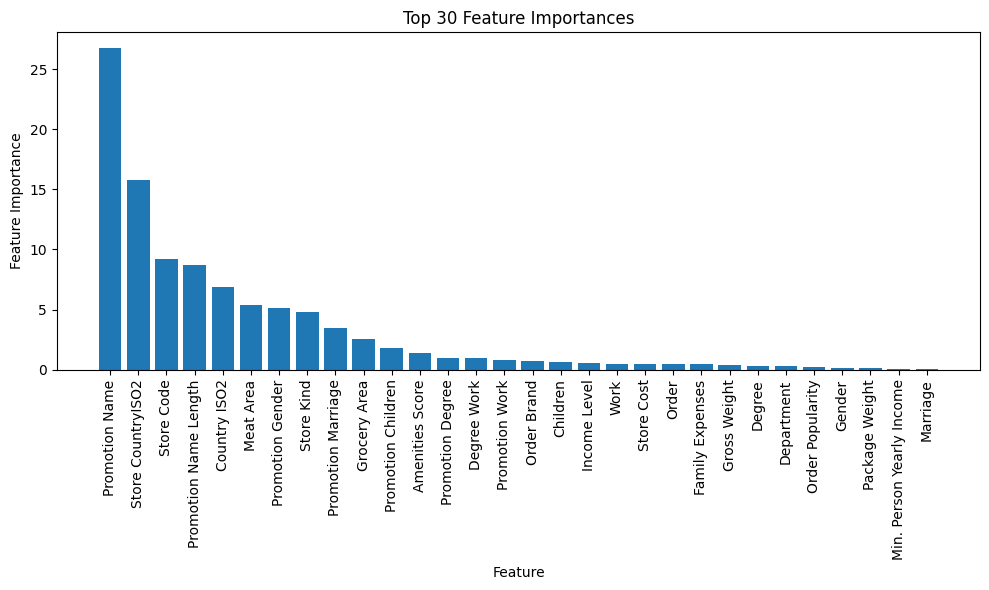

In [26]:
plot_feature_importance(cat.get_feature_importance(), X_train.columns, 30)

## Hyperparameter Tunning using GridSearch

### ExtraTrees

In [27]:
params = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': [6, 12, 18, 24, 30]
}

gs_ex = GridSearchCV(
    ExtraTreesRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_ex.fit(X_train_transformed, y_train)
gs_ex.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'max_depth': 18, 'n_estimators': 200}

In [28]:
exmodel = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=350, max_depth=16, n_jobs=-1, random_state=42)
)
exmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marriage',
       'Promotion Children', 'Promotion Degree', 'Promotion Work'],
      dtype='object'))])),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_depth=16, n_estimators=350, n_jobs=-1,
                                     random_state=42))])

In [29]:
y_train_pred = exmodel.predict(X_train)
y_test_pred = exmodel.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 21.859439432029372, test: 43.79576897889857


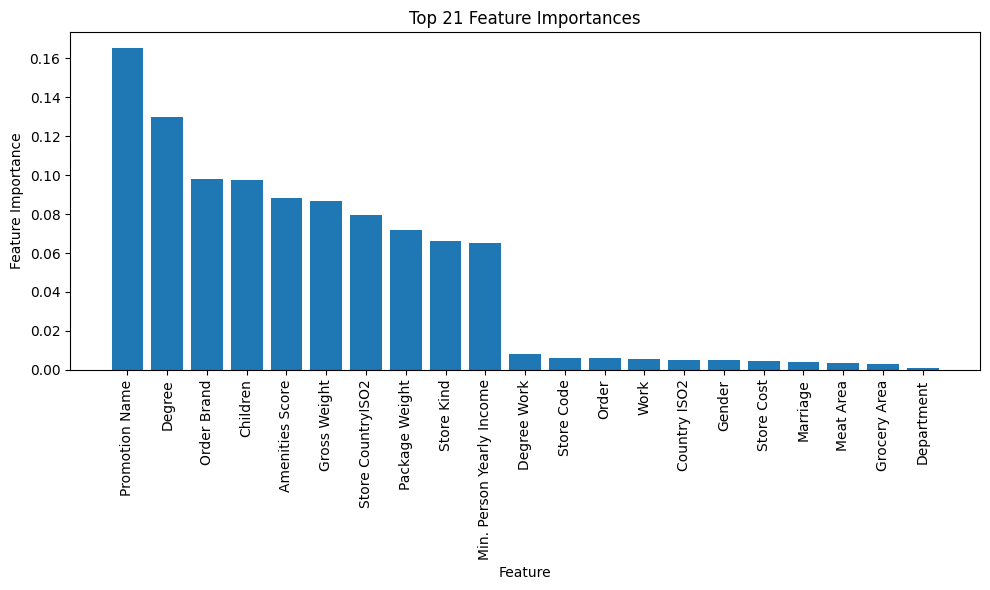

In [30]:
plot_feature_importance(exmodel.named_steps["extratreesregressor"].feature_importances_, X_train.columns[:21], 21)

### RandomForest

In [31]:
params = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': [6, 12, 18, 24, 30]
}

gs_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6, 12, 18, 24, 30],
                         'n_estimators': range(100, 1001, 100)},
             verbose=1)

In [32]:
rfmodel = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=400, max_depth=24, n_jobs=-1, random_state=42)
)
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marriage',
       'Promotion Children', 'Promotion Degree', 'Promotion Work'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=24, n_estimators=400,
                                       n_jobs=-1, random_state=42))])

In [33]:
y_train_pred = rfmodel.predict(X_train)
y_test_pred = rfmodel.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 17.69272247769826, test: 48.07588512580406


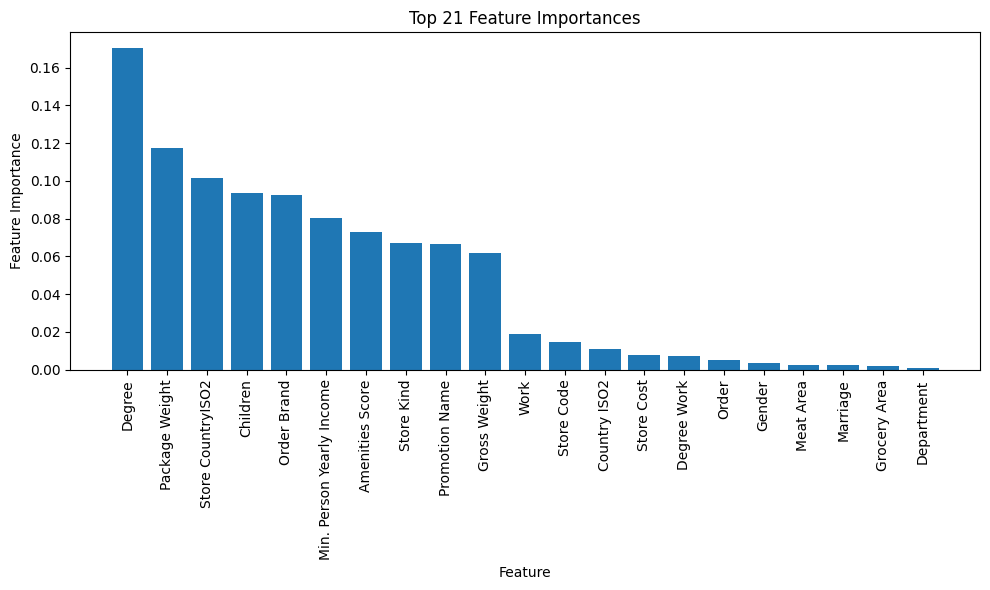

In [34]:
plot_feature_importance(rfmodel.named_steps["randomforestregressor"].feature_importances_, X_train.columns[:21], 21)

### Ensemble Voting

In [35]:
estimators = [
              ('rf', rfmodel),
              ('et', exmodel),
             ]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               Index(['Promotion Name', 'Store Kind', 'Degree Work', 'Marriage', 'Gender',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Prom...
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department', 'Store CountryISO2',
       'Income Level', 'Price Tier', 'Promotion Gender', 'Promotion Marriage',
       'Promotion Children', 'Promotion Degree', 'Promotion Work'],
      dtype='object'))])),
                                             ('extratreesregressor',
                                              ExtraTreesRegressor(max_depth=16,
                                                                  n_estimators=350,
                                                                  n_jobs=-1,
                                                                  random_state=42))]))])

In [36]:
y_train_pred = voting_model.predict(X_train)
y_test_pred = voting_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"train: {train_rmse}, test: {test_rmse}")

train: 19.14164819176657, test: 45.36948511718538


In [37]:
voting_model.score(X_test, y_test)

0.91669856779416

# Extract submissions

In [38]:
samples = pd.read_csv('data/sample_submission.csv')

test = pd.read_csv("data/test_data_cleaned.csv")

test = apply_feature_engineering(test)
print(test.shape)
test.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_submission.csv'

In [ ]:
test.isna().sum()

In [ ]:
y_sub_pred = exmodel.predict(test)
samples["Cost"] = y_sub_pred
samples.to_csv("data/submission.csv", index=False)